In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from sklearn.metrics import auc
from statistics import mean
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score


In [2]:
def calculate_auc_avg(tickers, predictions, true_values):
    predictions = predictions.sort_values(by='fecha')
    true_values = true_values.sort_values(by='fecha')
    
    
    # renombro las columnas
    column_names = {}
    for column in predictions.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_pred'
    
    predictions = predictions.rename(columns=column_names)
    
    column_names = {}
    for column in true_values.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_true'
    
    true_values = true_values.rename(columns=column_names)
    performance = pd.concat(
        [
            predictions,
            true_values
        ], axis=1, join="inner"
    )
    
    auc_list = []
    for ticker in tickers:
        y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
        y_pred = performance[performance[f'{ticker}_pred'].notna()][f'{ticker}_pred']
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        auc_list.append(precision)

    return mean(auc_list)

In [3]:
def max_drawdown(serie):
    max_valor_acumulado = serie[0]
    max_dd = 0

    for valor_actual in serie[1:]:
        if valor_actual > max_valor_acumulado:
            max_valor_acumulado = valor_actual
        else:
            dd = (max_valor_acumulado - valor_actual) / max_valor_acumulado
            if dd > max_dd:
                max_dd = dd

    return max_dd

In [4]:
def calculate_avg_returns_perc(orders):
    orders_per_month = orders[['close_time','profit', 'comment']].copy()
    orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
    orders_per_month['year'] = orders_per_month['close_time'].dt.year
    orders_per_month['month'] = orders_per_month['close_time'].dt.month
    
    orders_per_month_gb = orders_per_month.groupby(by=['year','month']).agg(
        profit_sum=('profit', 'sum'),
    ).reset_index()
    
    orders_per_month_gb = pd.concat([
        pd.DataFrame({'year':[2023], 'month':[0],'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
        orders_per_month_gb
    ])
    
    orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()
    
    orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'].shift(1))
    
    return orders_per_month_gb.perc_change.mean(), orders_per_month_gb.perc_change.std()

In [5]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)

In [6]:
tickers = config["tickers"] 
tickers

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF']

In [7]:
os.listdir('./backbone/data/backtest/experiments')

['Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7-UseDaysClose_False',
 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_multiclass',
 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_nobug_pattern',
 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_noround_nopattern',
 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_undersampling']

In [8]:
results_dict = {}
initial_wallet_value = config['start_money']

for path in os.listdir('./backbone/data/backtest/experiments'):
    if not path.endswith('.csv') and path.startswith('Mode_train'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

            final_wallet_value = wallet.tail(1).iloc[0]['wallet']
            results_dict[path]['wallet'] = ((final_wallet_value - initial_wallet_value) / initial_wallet_value) * 100
            results_dict[path]['max_drawdown'] = max_drawdown(wallet['wallet'])
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'orders.csv'))

            mean_returns, std_returns = calculate_avg_returns_perc(orders)
            results_dict[path]['mean_perc_returns'] = mean_returns
            results_dict[path]['std_perc_returns'] = std_returns
            
            
            results_dict[path]['buys'] = orders[orders['open_time'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_time'].notna()].shape[0]
           
            # avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            # results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] >= 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] < 0].shape[0]
    
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 
    
            results_dict[path]['sharpe_ratio'] = (orders['profit'].mean() - 0.04) / orders['profit'].std()
        
            results_dict[path]['winning_rate'] = orders[orders['profit'] >= 0]['profit'].mean() / (-1 * orders[orders['profit'] < 0]['profit'].mean())
            
            results_dict[path]['recover_factor'] = orders[orders['profit'] >= 0]['profit'].sum() / (-1 * orders[orders['profit'] < 0]['profit'].sum())

            results_dict[path]['stability_index'] = orders['profit'].std() / orders['profit'].mean()

            for ticker in tickers:
                results_dict[path][f'profits_in_{ticker}'] = orders[orders['ticker'] == ticker]['profit'].sum()

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0
        # try:
        # train_results = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'trainres.csv'))
        # avg_train_auc = train_results['precision'].mean()
        # results_dict[path]['avg_train_precision'] = avg_train_auc
        # # except:
        # #     results_dict[path]['avg_train_auc'] = 0
            
        # # try:
        # stock_predictions = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'preds.csv'))
        # true_values = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'truevals.csv'))

        # avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
        # results_dict[path]['avg_test_auc'] = avg_auc_score
        # except:
        #     results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')

Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7-UseDaysClose_False
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_multiclass
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_nobug_pattern
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_noround_nopattern
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_undersampling


In [9]:
beta = 0.05
eurusd = pd.read_csv('./backbone/data/backtest/symbols/EURUSD.csv')
results['buy_ratio'] = results['buys'] / (eurusd.Date.nunique() * len(tickers))
results['operation_ratio_2'] = ((1 + beta**2) * results['operation_ratio'] * results['buy_ratio']) / (beta * results['operation_ratio'] + results['buy_ratio'])

In [10]:
results.columns

Index(['wallet', 'max_drawdown', 'mean_perc_returns', 'std_perc_returns',
       'buys', 'sells', 'good_operations', 'bad_operations', 'operation_ratio',
       'sharpe_ratio', 'winning_rate', 'recover_factor', 'stability_index',
       'profits_in_EURUSD', 'profits_in_GBPUSD', 'profits_in_USDJPY',
       'profits_in_USDCAD', 'profits_in_AUDUSD', 'profits_in_USDCHF',
       'buy_ratio', 'operation_ratio_2'],
      dtype='object')

In [11]:
positive_results = results[
    [
        'operation_ratio_2',
        'operation_ratio', 
        'buy_ratio',
        'mean_perc_returns',
        'std_perc_returns',
        'winning_rate',
        'recover_factor',
        'sharpe_ratio',
        'stability_index',
        'max_drawdown',
        'good_operations',
        'bad_operations',
        'wallet',
        'profits_in_EURUSD',
        'profits_in_GBPUSD', 
        'profits_in_USDJPY', 
        'profits_in_USDCAD',
        'profits_in_AUDUSD', 
        'profits_in_USDCHF',
        # 'avg_train_precision',
        # 'avg_test_auc',
    ]
].sort_values(by=['sharpe_ratio'], ascending=[False])

# positive_results = positive_results[
#     (results['wallet']>100)
#     & (results['max_drawdown']<=0.16)
# ]

positive_results

,operation_ratio_2,operation_ratio,buy_ratio,mean_perc_returns,std_perc_returns,winning_rate,recover_factor,sharpe_ratio,stability_index,max_drawdown,good_operations,bad_operations,wallet,profits_in_EURUSD,profits_in_GBPUSD,profits_in_USDJPY,profits_in_USDCAD,profits_in_AUDUSD,profits_in_USDCHF
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_noround_nopattern,0.135349,0.346847,0.011053,0.042829,0.102045,2.220849,1.179348,0.056400,17.182057,0.192800,154,290,57.409237,136.19663,347.64571,37.714,-216.73757,-18.60232,287.87592
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7-UseDaysClose_False,0.150546,0.360465,0.012870,0.025283,0.083874,1.950442,1.099340,0.032395,28.747630,0.181480,186,330,30.040139,119.31753,124.82282,-48.701,-153.30206,33.22851,225.03559
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_multiclass,0.150546,0.360465,0.012870,0.025283,0.083874,1.950442,1.099340,0.032395,28.747630,0.181480,186,330,30.040139,119.31753,124.82282,-48.701,-153.30206,33.22851,225.03559
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_undersampling,0.230514,0.353253,0.032935,0.048979,0.154154,1.983951,1.083632,0.025532,35.565782,0.414609,467,855,57.529767,154.00851,-85.12551,0.393,6.80575,204.63314,294.58278
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7_nobug_pattern,0.157327,0.361511,0.013866,0.008386,0.090399,1.801553,1.020034,0.004460,136.875148,0.330443,201,355,5.709129,17.75321,123.23051,-64.259,-231.82499,7.44178,204.74978


In [12]:
columns = [
    'profits_in_EURUSD',
    'profits_in_GBPUSD', 
    'profits_in_USDJPY', 
    'profits_in_USDCAD',
    'profits_in_AUDUSD', 
    'profits_in_USDCHF'
]

positive_results[columns].describe()

,profits_in_EURUSD,profits_in_GBPUSD,profits_in_USDJPY,profits_in_USDCAD,profits_in_AUDUSD,profits_in_USDCHF
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,109.318682,127.079270,-24.710800,-149.672186,51.985924,247.455932
std,53.159652,153.056705,42.550487,94.549650,87.993941,40.877482
min,17.753210,-85.125510,-64.259000,-231.824990,-18.602320,204.749780
25%,119.317530,123.230510,-48.701000,-216.737570,7.441780,225.035590
50%,119.317530,124.822820,-48.701000,-153.302060,33.228510,225.035590
75%,136.196630,124.822820,0.393000,-153.302060,33.228510,287.875920
max,154.008510,347.645710,37.714000,6.805750,204.633140,294.582780


In [13]:
# results.loc[
#     [
#         'train_gradient_boosting_train_window_38_train_period_1_trading_strategy_strategies.bband_strategy',
#         'train_gradient_boosting_train_window_38_train_period_1_trading_strategy_strategies.macd_strategy',
#         'train_gradient_boosting_train_window_461_train_period_1_trading_strategy_strategies.bband_strategy',
#         'train_gradient_boosting_train_window_461_train_period_1_trading_strategy_strategies.macd_strategy',
#         'train_logistic_regression_train_window_38_train_period_1_trading_strategy_strategies.bband_strategy'
#     ]
# ]

In [14]:
# filter_results = results[results['wallet']>0]
# filter_results.shape

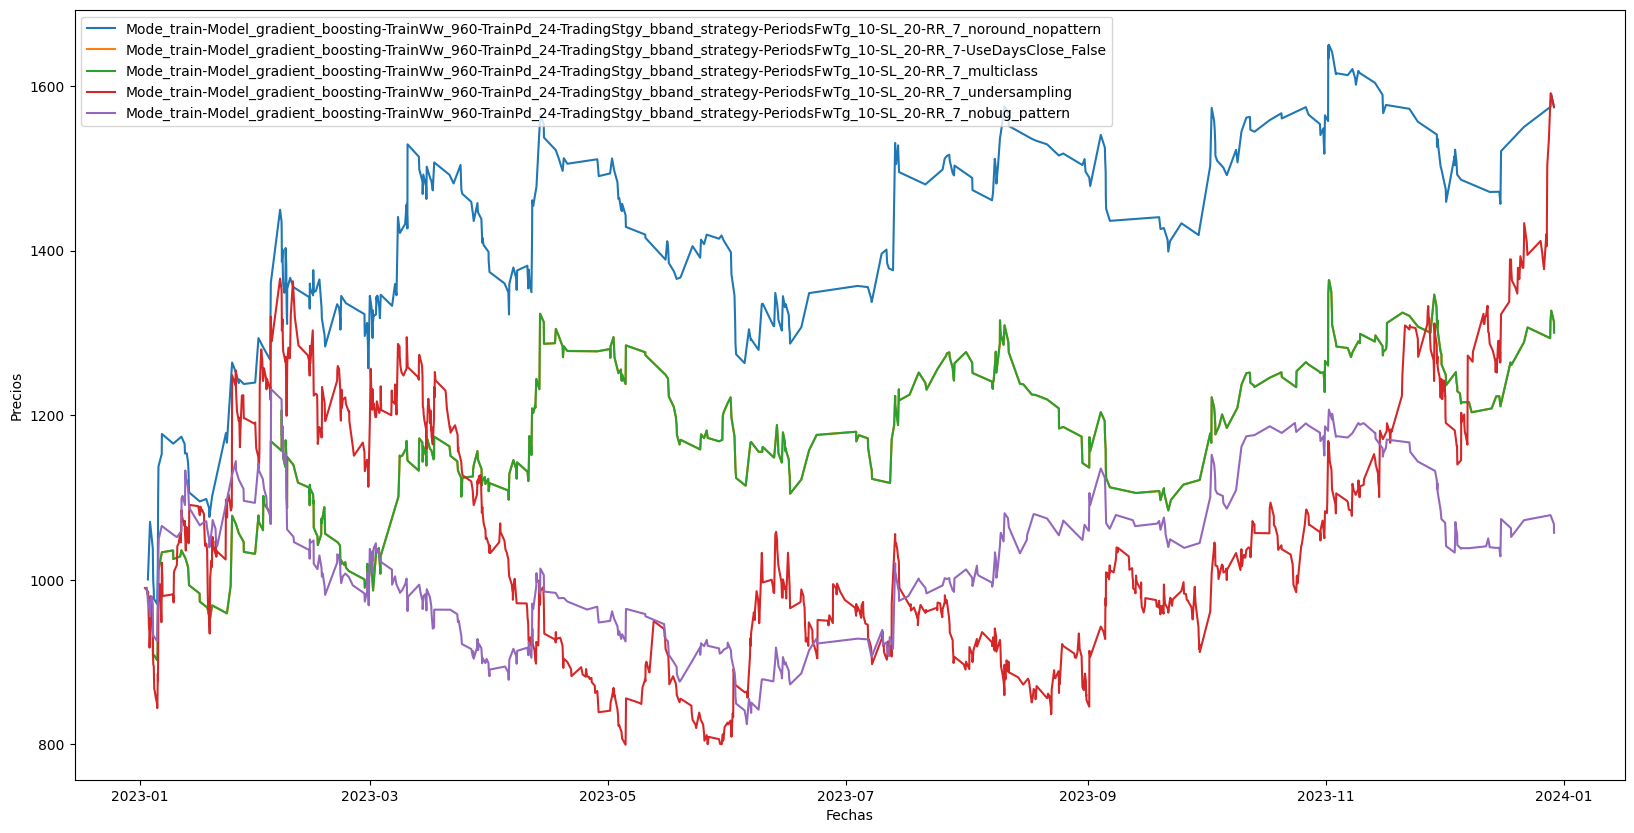

In [15]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

filter_results = positive_results
fig, ax = plt.subplots(figsize=(20, 10))
for path in filter_results.index:

    wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

    # Datos de ejemplo
    x_wallet = pd.to_datetime(wallet['date'])
    y_wallet = wallet['wallet']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x_wallet, y_wallet, label=f'{path}')
    
# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()
    
    # Mostrar el gráfico
    # print(path)
plt.show()
    # time.sleep(5)
    # clear_output(wait=True)

In [16]:
import re

In [17]:
filter_results = filter_results.reset_index().rename(columns={'index':'experiment'})

In [18]:
filter_results['model'] = filter_results['experiment'].apply(lambda x: re.search(r'-Model_(.*?)-', x).group(1))


In [19]:
filter_results['window'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainWw_(.*?)-', x).group(1))
filter_results['train_period'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainPd_(.*?)-', x).group(1))
filter_results['strategy'] = filter_results['experiment'].apply(lambda x: re.search(r'-TradingStgy_(.*?)-', x).group(1))
filter_results['periods_forward_target'] = filter_results['experiment'].apply(lambda x: re.search(r'-PeriodsFwTg_(.*?)-', x).group(1))
filter_results['sl'] = filter_results['experiment'].apply(lambda x: re.search(r'-SL_(.*?)-', x).group(1))
filter_results['rr'] = filter_results['experiment'].apply(lambda x: re.search(r'-RR_(.*?)-', x).group(1))
filter_results['use_days_to_close'] = filter_results['experiment'].apply(lambda x: x.split('UseDaysClose_')[1])

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
gb = filter_results.groupby(
    by=['strategy', 'model', 'window', 'rr', 'periods_forward_target']
).agg(
    {
        'max_drawdown':['mean', 'std']
    }
)


gb.sort_values(by=('max_drawdown', 'mean'), ascending=False).dropna().round(4)

In [ ]:
gb = filter_results.groupby(
    by=['rr']
).agg(
    {
        'winning_rate':['mean', 'std']
    }
)


gb

In [ ]:
gb = filter_results.groupby(
    by=['window']
).agg(
    {
        'winning_rate':['mean', 'std']
    }
)


gb.sort_values(by=('winning_rate', 'mean'))

In [ ]:
gb = filter_results.groupby(
    by=['periods_forward_target']
).agg(
    {
        'winning_rate':['mean', 'std']
    }
)


gb.sort_values(by=('winning_rate', 'mean'))

In [ ]:
0/0

In [ ]:
results_dict = {}

for path in os.listdir('./data'):
    if not path.endswith('.csv') and path.startswith('test_'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
            results_dict[path]['wallet'] = wallet.tail(1).iloc[0]['wallet']
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_date'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_date'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] > 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] <= 0].shape[0]
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0

        try:
            train_results = pd.read_csv(os.path.join('./data', path, 'train_results.csv'))
            avg_train_auc = train_results['auc'].mean()
            results_dict[path]['avg_train_auc'] = avg_train_auc
        except:
            results_dict[path]['avg_train_auc'] = 0
            
        try:
            stock_predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))
            true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))

            avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
            results_dict[path]['avg_test_auc'] = avg_auc_score
        except:
            results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')


Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False







Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False